### Import needed libraries
### Get the stock price history
### Drop unnecessary columns
### Display it in a plot

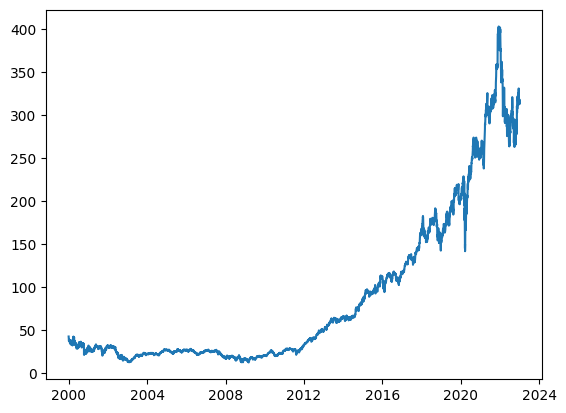

In [25]:
import yfinance
from matplotlib import pyplot as plt
import json
from datetime import *
import pandas as pd
import numpy as np

stock_abbr = 'HD'
start, end = '1999-12-31', '2022-12-31'

stock_ticker = yfinance.Ticker(stock_abbr)
stock = stock_ticker.history(start=start, end=end)

stock = stock.drop(columns=['Dividends', 'Volume', 'Stock Splits'])

plt.plot(stock['Close'])
plt.show()


### Add the low and high prices of the stock from the day before to each row
### Find in what days there was a gap and its type

In [26]:
stock['High_t-1'] = stock.High.shift(1)
stock['Low_t-1'] = stock.Low.shift(1)
stock['Close_t-1'] = stock.Close.shift(1)
stock = stock.tail(-1)

stock['is_gap'] = [stock['High_t-1'][i] < stock['Low'][i] or stock['Low_t-1'][i] > stock['High'][i] for i in range(len(stock))]
stock['is_gap_up'] = [stock['High_t-1'][i] < stock['Low'][i] for i in range(len(stock))]

stock

,Open,High,Low,Close,High_t-1,Low_t-1,Close_t-1,is_gap,is_gap_up
Date,,,,,,,,,
2000-01-03,42.772141,43.122733,39.772638,40.629639,43.473321,41.915138,42.850048,False,False
2000-01-04,39.889502,40.084275,38.175500,38.487137,43.122733,39.772638,40.629639,False,False
2000-01-05,38.487132,39.266224,38.019677,39.266224,40.084275,38.175500,38.487137,False,False
2000-01-06,38.409220,38.642947,37.396400,37.396400,39.266224,38.019677,39.266224,False,False
2000-01-07,38.487144,39.577873,37.863871,39.577873,38.642947,37.396400,37.396400,False,False
...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,314.125245,308.496027,313.847260,False,False
2022-12-27,316.120806,319.238215,315.227282,317.252594,316.805842,310.809258,316.438507,False,False
2022-12-28,318.245376,319.119054,313.231695,313.460052,319.238215,315.227282,317.252594,False,False


### Add how many days took the gap to be filled for each gap
### Add the extremum of the time between the gap and when it was filled and the max return from that gap
### Add the gap size and its ratio

In [27]:
stock['gap_fill_time'] = None
stock['extremum'] = None
stock['max_return'] = None
stock['gap_size'] = None
stock['gap_size_ratio'] = None
gaps_up = []
gaps_down = []

for index, row in stock.iterrows():
    while gaps_up and row['Low'] <= gaps_up[-1][1]:
        stock.loc[gaps_up[-1][0], 'gap_fill_time'] = (index - gaps_up[-1][0]).days
        gaps_up.pop()
    while gaps_down and row['High'] >= gaps_down[-1][1]:
        stock.loc[gaps_down[-1][0], 'gap_fill_time'] = (index - gaps_down[-1][0]).days
        gaps_down.pop()
    if row['is_gap']:
        gaps_up.append([index, row['High_t-1'], row['High']]) if row['is_gap_up'] else gaps_down.append([index, row['Low_t-1'], row['Low']])
        stock.loc[index, 'gap_size'] = row['Low'] - row['High_t-1'] if row['is_gap_up'] else row['Low_t-1'] - row['High']
        stock.loc[index, 'gap_size_ratio'] = (row['Low'] / row['High_t-1']) - 1 if row['is_gap_up'] else 1 - (row['High'] / row['Low_t-1'])
        stock.loc[index, 'extremum'] = row['High'] if row['is_gap_up'] else row['Low']
        stock.loc[index, 'max_return'] = stock.loc[index, 'gap_size_ratio']
    i = len(gaps_up) - 1
    while gaps_up and row['High'] > gaps_up[i][2]:
        gaps_up[i][2] = row['High']
        stock.loc[gaps_up[i][0], 'extremum'] = row['High']
        stock.loc[gaps_up[i][0], 'max_return'] = (row['High'] / stock.loc[gaps_up[i][0], 'High_t-1']) - 1
        i -= 1
    i = len(gaps_down) - 1
    while gaps_down and row['Low'] < gaps_down[i][2]:
        gaps_down[i][2] = row['Low']
        stock.loc[gaps_down[i][0], 'extremum'] = row['Low']
        stock.loc[gaps_down[i][0], 'max_return'] = 1 - (row['Low'] / stock.loc[gaps_down[i][0], 'Low_t-1'])
        i -= 1


stock

,Open,High,Low,Close,High_t-1,Low_t-1,Close_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio
Date,,,,,,,,,,,,,,
2000-01-03,42.772141,43.122733,39.772638,40.629639,43.473321,41.915138,42.850048,False,False,None,None,None,None,None
2000-01-04,39.889502,40.084275,38.175500,38.487137,43.122733,39.772638,40.629639,False,False,None,None,None,None,None
2000-01-05,38.487132,39.266224,38.019677,39.266224,40.084275,38.175500,38.487137,False,False,None,None,None,None,None
2000-01-06,38.409220,38.642947,37.396400,37.396400,39.266224,38.019677,39.266224,False,False,None,None,None,None,None
2000-01-07,38.487144,39.577873,37.863871,39.577873,38.642947,37.396400,37.396400,False,False,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,314.125245,308.496027,313.847260,False,False,None,None,None,None,None
2022-12-27,316.120806,319.238215,315.227282,317.252594,316.805842,310.809258,316.438507,False,False,None,None,None,None,None
2022-12-28,318.245376,319.119054,313.231695,313.460052,319.238215,315.227282,317.252594,False,False,None,None,None,None,None


### display the max, min, and average of the following features: gap fill time, max return, and gap size ratio

In [28]:
gaps_up_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps_up = stock[stock['is_gap_up']]
no_of_gaps_up = len(stock_gaps_up)
gaps_up_analysis.loc['fill_time','max'] = stock_gaps_up.loc[:,'gap_fill_time'].max()
gaps_up_analysis.loc['fill_time','min'] = stock_gaps_up.loc[:,'gap_fill_time'].min()
gaps_up_analysis.loc['fill_time','avg'] = stock_gaps_up.loc[:,'gap_fill_time'].mean()
gaps_up_analysis.loc['max_return','max'] = stock_gaps_up.loc[:,'max_return'].max()
gaps_up_analysis.loc['max_return','min'] = stock_gaps_up.loc[:,'max_return'].min()
gaps_up_analysis.loc['max_return','avg'] = stock_gaps_up.loc[:,'max_return'].mean()
gaps_up_analysis.loc['gap_size_ratio','max'] = stock_gaps_up.loc[:,'gap_size_ratio'].max()
gaps_up_analysis.loc['gap_size_ratio','min'] = stock_gaps_up.loc[:,'gap_size_ratio'].min()
gaps_up_analysis.loc['gap_size_ratio','avg'] = stock_gaps_up.loc[:,'gap_size_ratio'].mean()

print(f'number of gaps up: {no_of_gaps_up}')
print(gaps_up_analysis)

gaps_down_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps = stock[stock['is_gap']]
stock_gaps_down = stock_gaps[stock_gaps['is_gap_up'] == False]
no_of_gaps_down = len(stock_gaps_down)
gaps_down_analysis.loc['fill_time','max'] = stock_gaps_down.loc[:,'gap_fill_time'].max()
gaps_down_analysis.loc['fill_time','min'] = stock_gaps_down.loc[:,'gap_fill_time'].min()
gaps_down_analysis.loc['fill_time','avg'] = stock_gaps_down.loc[:,'gap_fill_time'].mean()
gaps_down_analysis.loc['max_return','max'] = stock_gaps_down.loc[:,'max_return'].max()
gaps_down_analysis.loc['max_return','min'] = stock_gaps_down.loc[:,'max_return'].min()
gaps_down_analysis.loc['max_return','avg'] = stock_gaps_down.loc[:,'max_return'].mean()
gaps_down_analysis.loc['gap_size_ratio','max'] = stock_gaps_down.loc[:,'gap_size_ratio'].max()
gaps_down_analysis.loc['gap_size_ratio','min'] = stock_gaps_down.loc[:,'gap_size_ratio'].min()
gaps_down_analysis.loc['gap_size_ratio','avg'] = stock_gaps_down.loc[:,'gap_size_ratio'].mean()

print(f'\nnumber of gaps down: {no_of_gaps_down}')
print(gaps_down_analysis)

number of gaps up: 241
                      max  min        avg
fill_time            2061    1  76.712329
max_return      14.823979  0.0   0.576563
gap_size_ratio   0.044673  0.0   0.005741

number of gaps down: 165
                     max  min        avg
fill_time           3479    1  45.359756
max_return      0.608793  0.0   0.069019
gap_size_ratio    0.2235  0.0   0.008722


### Scrape Yahoo Finance and retreive the quarterly earning per share of the stock and its earning announcement timing

In [29]:
!node get_earnings.js {stock_abbr}

f = open(f'{stock_abbr}.json')
earnings = json.load(f)
print(earnings)
f.close()

!rm {stock_abbr}.json

[{'date': '2024-02-19', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-11-14', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-08-15', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-05-16', 'eps': None, 'estimated_eps': 3.86, 'timing': 1}, {'date': '2023-02-21', 'eps': 3.3, 'estimated_eps': 3.28, 'timing': 0}, {'date': '2022-11-15', 'eps': 4.24, 'estimated_eps': 4.12, 'timing': 0}, {'date': '2022-08-16', 'eps': 5.05, 'estimated_eps': 4.94, 'timing': 0}, {'date': '2022-05-17', 'eps': 4.09, 'estimated_eps': 3.68, 'timing': 0}, {'date': '2022-02-22', 'eps': 3.21, 'estimated_eps': 3.18, 'timing': 0}, {'date': '2021-11-16', 'eps': 3.92, 'estimated_eps': 3.4, 'timing': 0}, {'date': '2021-08-17', 'eps': 4.53, 'estimated_eps': 4.44, 'timing': 0}, {'date': '2021-05-18', 'eps': 3.86, 'estimated_eps': 3.08, 'timing': 0}, {'date': '2021-02-23', 'eps': 2.65, 'estimated_eps': 2.62, 'timing': 0}, {'date': '2020-11-17', 'eps': 3.18, 'estimated_eps':

### assign the most relevant quarterly earning per share to each row
### added a feature that indicate if earning was announced at that day
### added a feature that indicated the timing of the earning announcment (-1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period)

In [30]:
stock['eps'] = None
stock['estimated_eps'] = None
stock['is_earn_day'] = False
stock['earn_timing'] = -1 # -1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period

for i in range(len(earnings)):
    if earnings[i]['eps']:
        if earnings[i]['date'] in stock.index:
            stock.loc[earnings[i]['date'], 'is_earn_day'] = True
            stock.loc[earnings[i]['date'], 'earn_timing'] = earnings[i]['timing']
            stock.loc[earnings[i]['date'], 'eps'] = earnings[i]['eps']
            stock.loc[earnings[i]['date'], 'estimated_eps'] = earnings[i]['estimated_eps']
stock

,Open,High,Low,Close,High_t-1,Low_t-1,Close_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio,eps,estimated_eps,is_earn_day,earn_timing
Date,,,,,,,,,,,,,,,,,,
2000-01-03,42.772141,43.122733,39.772638,40.629639,43.473321,41.915138,42.850048,False,False,None,None,None,None,None,None,None,False,-1
2000-01-04,39.889502,40.084275,38.175500,38.487137,43.122733,39.772638,40.629639,False,False,None,None,None,None,None,None,None,False,-1
2000-01-05,38.487132,39.266224,38.019677,39.266224,40.084275,38.175500,38.487137,False,False,None,None,None,None,None,None,None,False,-1
2000-01-06,38.409220,38.642947,37.396400,37.396400,39.266224,38.019677,39.266224,False,False,None,None,None,None,None,None,None,False,-1
2000-01-07,38.487144,39.577873,37.863871,39.577873,38.642947,37.396400,37.396400,False,False,None,None,None,None,None,None,None,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,314.125245,308.496027,313.847260,False,False,None,None,None,None,None,None,None,False,-1
2022-12-27,316.120806,319.238215,315.227282,317.252594,316.805842,310.809258,316.438507,False,False,None,None,None,None,None,None,None,False,-1
2022-12-28,318.245376,319.119054,313.231695,313.460052,319.238215,315.227282,317.252594,False,False,None,None,None,None,None,None,None,False,-1


### calculate the percentage of times the stock went up during the nonmarket hours when earnings were announced at the nonmarket hours
### calculate the average return during the nonmarket hours when earnings were announced at the nonmarket hours
### calculate the correaltion coefficient of the nonmarket hours return and the eps to its estimation estimation ratio when earnings is announced at nonmarket hours
### calculate the correaltion coefficient of the nonmarket hours return and the eps to the previous eps ratio when earnings is announced at nonmarket hours

In [31]:
earn_count, earn_up_count, earn_return_sum = 0, 0, 0.0
returns, estimations, eps_change, returns2 = [], [], [], []
for i in range(len(earnings)):
    if earnings[i]['eps'] and earnings[i]['date'] in stock.index:
        if stock.loc[earnings[i]['date'], 'earn_timing'] == 0:
            earn_count += 1
            earn_up_count += 1 if stock.loc[earnings[i]['date'], 'Open'] > stock.loc[earnings[i]['date'], 'Close_t-1'] else 0
            earn_return_sum += stock.loc[earnings[i]['date'], 'Open'] / stock.loc[earnings[i]['date'], 'Close_t-1']
            returns.append(stock.loc[earnings[i]['date'], 'Open'] / stock.loc[earnings[i]['date'], 'Close_t-1'])
            estimations.append(stock.loc[earnings[i]['date'], 'eps'] / stock.loc[earnings[i]['date'], 'estimated_eps'])
            if i < len(earnings) - 1 and earnings[i+1]['eps'] and earnings[i+1]['date'] in stock.index:
                eps_change.append(stock.loc[earnings[i]['date'], 'eps'] / stock.loc[earnings[i+1]['date'], 'eps'])
                returns2.append(stock.loc[earnings[i]['date'], 'Open'] / stock.loc[earnings[i]['date'], 'Close_t-1'])
        elif stock.loc[earnings[i]['date'], 'earn_timing'] == 2:
            earn_count += 1
            earn_up_count += 1 if stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Open'] > stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Close_t-1'] else 0
            earn_return_sum += stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Open'] / stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Close_t-1']
            returns.append(stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Open'] / stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Close_t-1'])
            estimations.append(stock.loc[earnings[i]['date'], 'eps'] / stock.loc[earnings[i]['date'], 'estimated_eps'])
            if i < len(earnings) - 1 and earnings[i+1]['eps'] and earnings[i+1]['date'] in stock.index:
                eps_change.append(stock.loc[earnings[i]['date'], 'eps'] / stock.loc[earnings[i+1]['date'], 'eps'])
                returns2.append(stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Open'] / stock.loc[earnings[i]['date'] + datetime.timedelta(days=1), 'Close_t-1'])
        
print(f'{stock_abbr} went up {round(100 * earn_up_count / earn_count,2)}% of the times during the nonmarket hours when earnings were announced at the nonmarket hours')
print(f'{stock_abbr} average return during the nonmarket hours when earnings were announced at the nonmarket hours is {round(100 * earn_return_sum / earn_count - 100, 2)}%')
print(f'The correlation coefficient of the nonmarket hours return and the eps to its estimation eps ratio is {np.corrcoef(returns, estimations)[0][1]} when earnings is announced at nonmarket hours')
print(f'The correlation coefficient of the nonmarket hours return and the eps to its previous eps ratio is {np.corrcoef(returns2, eps_change)[0][1]} when earnings is announced at nonmarket hours')

HD went up 63.04% of the times during the nonmarket hours when earnings were announced at the nonmarket hours
HD average return during the nonmarket hours when earnings were announced at the nonmarket hours is 0.78%
The correlation coefficient of the nonmarket hours return and the eps to its estimation eps ratio is 0.25992907202550203 when earnings is announced at nonmarket hours
[0.9906815974714824, 0.9948191119373326, 1.0355079500644293, 0.9660391680669927, 1.0294275966777702, 0.9580660005505731, 0.9999688476812881, 0.9765452554418966, 0.973280314808793, 1.002289807342455, 0.9800285329219736, 1.0267002805178367, 0.9654596609279095, 1.0266894207601818, 0.9799947938011103, 0.9768923247583647, 0.988128997830866, 1.0053056424178404, 0.99173116288211, 1.0156710851895878, 0.9895375716797585, 1.0001296496161922, 1.017669923009201, 1.0181817447591508, 0.9953005877379579, 1.0043041346346187, 0.9838185461724097, 1.0337810937897778, 1.033267051094121, 1.0177942719665578, 1.0156567852375624, 1.0